In [1]:
import sys 
import numpy as np # linear algebra
from scipy.stats import randint
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph 
import seaborn as sns # used for plot interactive graph. 
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.model_selection import KFold # use for cross validation
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score

import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
#reading the file
df = pd.read_csv('dataset.csv')

In [3]:
df.dtypes

SystemCodeNumber    object
Capacity             int64
Occupancy            int64
LastUpdated         object
dtype: object

In [4]:
df.head()

,SystemCodeNumber,Capacity,Occupancy,LastUpdated
0,BHMBCCMKT01,577,61,2016-10-04 07:59:42
1,BHMBCCMKT01,577,64,2016-10-04 08:25:42
2,BHMBCCMKT01,577,80,2016-10-04 08:59:42
3,BHMBCCMKT01,577,107,2016-10-04 09:32:46
4,BHMBCCMKT01,577,150,2016-10-04 09:59:48


In [5]:
import datetime as dt
df['LastUpdated'] = pd.to_datetime(df['LastUpdated'])

In [6]:
df.dtypes

SystemCodeNumber            object
Capacity                     int64
Occupancy                    int64
LastUpdated         datetime64[ns]
dtype: object

In [7]:
df.isnull().sum()

SystemCodeNumber    0
Capacity            0
Occupancy           0
LastUpdated         0
dtype: int64

In [8]:
df.dropna()

,SystemCodeNumber,Capacity,Occupancy,LastUpdated
0,BHMBCCMKT01,577,61,2016-10-04 07:59:42
1,BHMBCCMKT01,577,64,2016-10-04 08:25:42
2,BHMBCCMKT01,577,80,2016-10-04 08:59:42
3,BHMBCCMKT01,577,107,2016-10-04 09:32:46
4,BHMBCCMKT01,577,150,2016-10-04 09:59:48
...,...,...,...,...
35712,Shopping,1920,1517,2016-12-19 14:30:33
35713,Shopping,1920,1487,2016-12-19 15:03:34
35714,Shopping,1920,1432,2016-12-19 15:29:33
35715,Shopping,1920,1321,2016-12-19 16:03:35


In [9]:
df.columns

Index(['SystemCodeNumber', 'Capacity', 'Occupancy', 'LastUpdated'], dtype='object')

# DATA Pre-Processing

In [10]:
# making 'LastUpdated'asindex
df= df.set_index('LastUpdated')

In [11]:
#deleting the SystemCodeNumber
del df['SystemCodeNumber']


In [12]:

df = df[['Occupancy','Capacity']]
df.head()

,Occupancy,Capacity
LastUpdated,,
2016-10-04 07:59:42,61,577
2016-10-04 08:25:42,64,577
2016-10-04 08:59:42,80,577
2016-10-04 09:32:46,107,577
2016-10-04 09:59:48,150,577


In [13]:
#resampling
df_resample = df.resample('h').mean()


In [14]:
df_resample.shape

(1834, 2)

# FUNCTION TO PREPARE OUR DATASETS CONSIDERING THE SEQUENCE:



In [15]:

def seriesToSupervised(scaled, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(scaled) is list else scaled.shape[1]
    dff = pd.DataFrame(scaled)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(-i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i==0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1)) for j in range(n_vars)]
        
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        if dropnan:
            agg.dropna(inplace=True)
        return agg

In [16]:
values = df_resample
#normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = seriesToSupervised(scaled, 1, 1)


In [17]:

reframed.head()





,var1(t-1),var2(t-1),var1(t),var2(t)
0,0.357032,0.806859,0.223392,0.774194
1,0.524287,0.806859,0.357032,0.806859
2,0.649520,0.806859,0.524287,0.806859
3,0.732658,0.812816,0.649520,0.806859
4,0.761433,0.807930,0.732658,0.812816


In [18]:
# drop columns don't want to predict
reframed.drop(reframed.columns[[2]], axis=1, inplace=True)


In [19]:
reframed.head()

,var1(t-1),var2(t-1),var2(t)
0,0.357032,0.806859,0.774194
1,0.524287,0.806859,0.806859
2,0.649520,0.806859,0.806859
3,0.732658,0.812816,0.806859
4,0.761433,0.807930,0.812816


In [20]:
values = reframed.values

#splitting the dataset 90:10 as total sample 639 

n_train_time = 575
train = values[:n_train_time, :]
test = values[n_train_time:, :]
train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))

In [21]:
#train_x.shape
test_x.shape

(64, 1, 2)

# Creating the model

In [22]:
model = Sequential()
model.add(LSTM(120, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [23]:

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 120)               59040     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 121       
Total params: 59,161
Trainable params: 59,161
Non-trainable params: 0
_________________________________________________________________


In [24]:
import matplotlib.pyplot 

# model fit
history = model.fit(train_x, train_y, epochs=100, batch_size=72, validation_data=(test_x, test_y),
                    verbose=2, shuffle=False)





Train on 575 samples, validate on 64 samples
Epoch 1/100
 - 0s - loss: 0.7496 - val_loss: 0.6830
Epoch 2/100
 - 0s - loss: 0.6612 - val_loss: 0.5917
Epoch 3/100
 - 0s - loss: 0.5709 - val_loss: 0.4958
Epoch 4/100
 - 0s - loss: 0.4740 - val_loss: 0.3924
Epoch 5/100
 - 0s - loss: 0.3660 - val_loss: 0.2752
Epoch 6/100
 - 0s - loss: 0.2430 - val_loss: 0.1399
Epoch 7/100
 - 0s - loss: 0.1130 - val_loss: 0.0903
Epoch 8/100
 - 0s - loss: 0.0909 - val_loss: 0.1216
Epoch 9/100
 - 0s - loss: 0.0805 - val_loss: 0.0778
Epoch 10/100
 - 0s - loss: 0.0706 - val_loss: 0.0678
Epoch 11/100
 - 0s - loss: 0.0722 - val_loss: 0.0757
Epoch 12/100
 - 0s - loss: 0.0695 - val_loss: 0.0791
Epoch 13/100
 - 0s - loss: 0.0671 - val_loss: 0.0706
Epoch 14/100
 - 0s - loss: 0.0667 - val_loss: 0.0696
Epoch 15/100
 - 0s - loss: 0.0659 - val_loss: 0.0706
Epoch 16/100
 - 0s - loss: 0.0647 - val_loss: 0.0685
Epoch 17/100
 - 0s - loss: 0.0639 - val_loss: 0.0681
Epoch 18/100
 - 0s - loss: 0.0630 - val_loss: 0.0674
Epoch 19/1

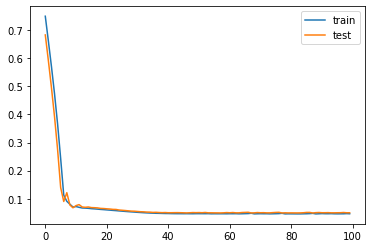

In [25]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# ploting the loss for train & test
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()

In [26]:
#PRedicitng & calculaitng RMSE
yhat = model.predict(test_x)
test_x = test_x.reshape((test_x.shape[0], test_x.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_x[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_x[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 171.612


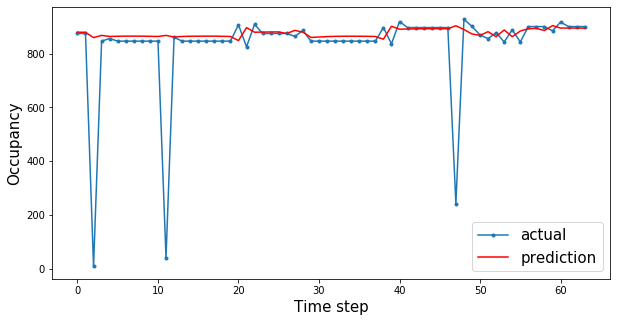

In [30]:
#Showing the actual & prediction results
aa=[x for x in range(64)]
plt.figure(figsize = (10, 5))
plt.plot(aa, inv_y[:64], marker='.', label="actual")
plt.plot(aa, inv_yhat[:64], 'r', label="prediction")
plt.ylabel('Occupancy', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()